In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv('C:\\Users\\bumbk\\causal-inference-in-python-code\\실무로 통하는 인과추론 with 파이썬\\data\\cross_sell_email.csv')
data.head()

,gender,cross_sell_email,age,conversion
0,0,short,15,0
1,1,short,27,0
2,1,long,17,0
3,1,long,34,0
4,1,no_email,14,0


In [3]:
len(data)

323

In [5]:
(data
.groupby(["cross_sell_email"])
.mean())

,gender,age,conversion
cross_sell_email,,,
long,0.550459,21.752294,0.055046
no_email,0.542553,20.489362,0.042553
short,0.633333,20.991667,0.125000


In [7]:
X = ["gender", "age"]

mu = data.groupby("cross_sell_email")[X].mean()
var = data.groupby("cross_sell_email")[X].var()

norm_diff = ((mu - mu.loc["no_email"])/
            np.sqrt((var + var.loc["no_email"])/2))

norm_diff

,gender,age
cross_sell_email,,
long,0.015802,0.221423
no_email,0.000000,0.000000
short,0.184341,0.087370


1.2.4 가장 위험한 수식

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
from cycler import cycler
import matplotlib

In [2]:
default_cycler = (cycler(color=['0.1','0.5','1.0']))

color = ['0.3','0.5','0.7','0.9']
linestyle = ['-','--',':','-.']
marker = ['o','v','d','p']

plt.rc('axes',prop_cycle=default_cycler)

matplotlib.rcParams.update({'font.size': 18})

In [3]:
df = pd.read_csv('C:\\Users\\bumbk\\causal-inference-in-python-code\\실무로 통하는 인과추론 with 파이썬\\data\\enem_scores.csv')
df

,year,school_id,number_of_students,avg_score
0,2007,11000058,144,69.03
1,2006,11000058,184,57.82
2,2005,11000058,220,64.83
3,2006,11000198,51,51.69
4,2005,11000198,47,50.16
...,...,...,...,...
37936,2006,53013999,177,59.81
37937,2007,53013999,131,73.18
37938,2005,53014111,131,57.61
37939,2006,53014111,181,54.38


In [4]:
df.sort_values(by='avg_score', ascending=False).head(10)

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
18121,2007,33152314,14,79.82
16781,2007,33065250,80,79.67
3026,2007,22025740,144,79.52
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


Text(0.5, 1.0, 'Number of Students of 1% Top Schools (Right)')

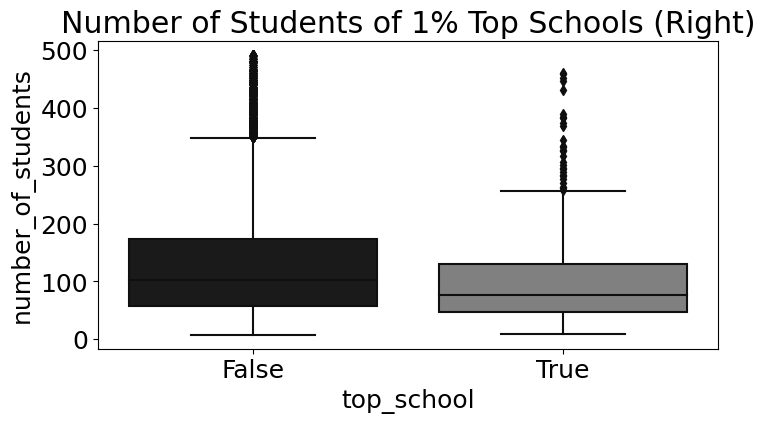

In [5]:
plot_data = (df.assign(top_school = df['avg_score'] >= np.quantile(df['avg_score'], .99))
            [['top_school', 'number_of_students']]
            .query(f"number_of_students<{np.quantile(df['number_of_students'], .98)}")) #remove outliers

plt.figure(figsize=(8,4))
ax = sns.boxplot(x='top_school', y='number_of_students', data=plot_data)
plt.title("Number of Students of 1% Top Schools (Right)")

Text(0.5, 1.0, 'ENEM Score by Number of Students')

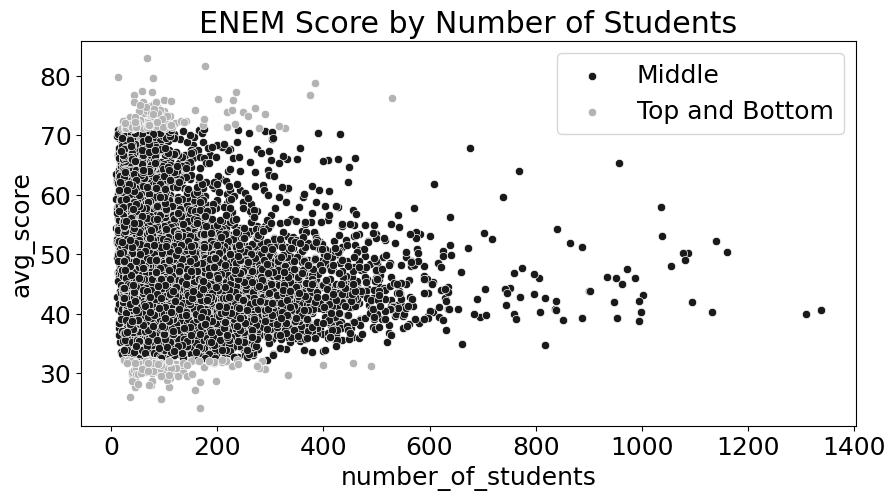

In [6]:
q_99 = np.quantile(df['avg_score'], .99)
q_01 = np.quantile(df['avg_score'], .01)

plot_data = (df
            .sample(10000)
            .assign(Group = lambda d: np.select([(d['avg_score'] > q_99) | (d['avg_score'] < q_01)],
                                               ['Top and Bottom'], 'Middle')))
plt.figure(figsize=(10,5))
sns.scatterplot(y='avg_score', x='number_of_students', data=plot_data.query('Group=="Middle"'), label="Middle")
ax = sns.scatterplot(y='avg_score', x='number_of_students', data=plot_data.query('Group!="Middle"'), color='0.7', label='Top and Bottom')

plt.title('ENEM Score by Number of Students')

In [7]:
data = pd.read_csv('C:\\Users\\bumbk\\causal-inference-in-python-code\\실무로 통하는 인과추론 with 파이썬\\data\\cross_sell_email.csv')


short_email = data.query('cross_sell_email=="short"')['conversion']
long_email = data.query('cross_sell_email=="long"')['conversion']

email = data.query('cross_sell_email!="no_email"')['conversion']
no_email = data.query('cross_sell_email=="no_email"')['conversion']

data.groupby('cross_sell_email').size()

cross_sell_email
long        109
no_email     94
short       120
dtype: int64

표준오차 추정

In [8]:
def se(y: pd.Series):
    return y.std() / np.sqrt(len(y))

print('SE for Long Email:', se(long_email))
print('SE for Short Email:', se(short_email))

SE for Long Email: 0.02194602460918551
SE for Short Email: 0.030316953129541618


In [9]:
print('SE for Long Email:', long_email.sem())
print('SE for Short Email:', short_email.sem())

SE for Long Email: 0.02194602460918551
SE for Short Email: 0.030316953129541618


In [12]:
    n = 100
    conv_rate = 0.08
    
    def run_experiment():
        return np.random.binomial(1, conv_rate, size=n)
    
    np.random.seed(42)
    
    experiments = [run_experiment().mean() for _ in range(10000)]

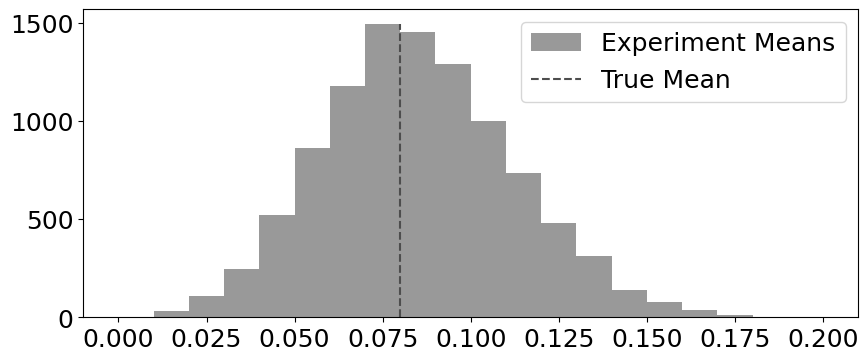

In [13]:
plt.figure(figsize=(10,4))
freq, bins, img = plt.hist(experiments, bins=20, label="Experiment Means", color="0.6")
plt.vlines(conv_rate, ymin=0, ymax=freq.max(), linestyles="dashed", label="True Mean", color="0.3")
plt.legend()

In [15]:
exp_se = short_email.sem()
exp_mu = short_email.mean()
ci = (exp_mu - 2 * exp_se, exp_mu + 2 * exp_se)
print('95% CI for Short Email: ', ci)

95% CI for Short Email:  (0.06436609374091676, 0.18563390625908324)


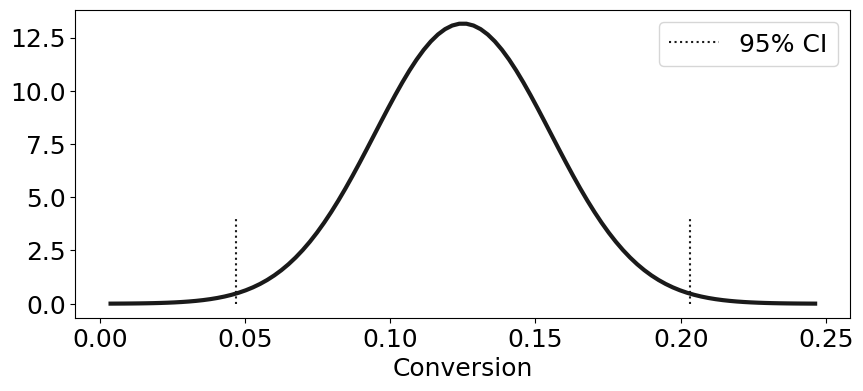

In [18]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)

plt.figure(figsize=(10,4))
plt.plot(x, y, lw=3)
plt.vlines(ci[1], ymin=0, ymax=4, ls="dotted")
plt.vlines(ci[0], ymin=0, ymax=4, ls="dotted", label="95% CI")
plt.xlabel("Conversion")
plt.legend()

In [16]:
from scipy import stats

z = np.abs(stats.norm.ppf((1-.99)/2))
print(z)

ci = (exp_mu - z * exp_se, exp_mu + z * exp_se)
ci

2.5758293035489004


(0.04690870373460816, 0.20309129626539185)

In [17]:
stats.norm.ppf((1-.99)/2)

-2.5758293035489004

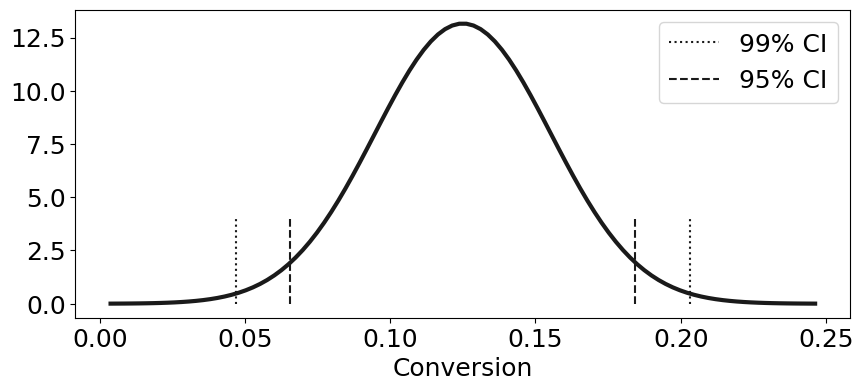

In [19]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)

plt.figure(figsize=(10,4))
plt.plot(x, y, lw=3)
plt.vlines(ci[1], ymin=0, ymax=4, ls="dotted")
plt.vlines(ci[0], ymin=0, ymax=4, ls="dotted", label="99% CI")


ci_95 = (exp_mu - 1.96 * exp_se, exp_mu + 1.96 * exp_se)

plt.vlines(ci_95[1], ymin=0, ymax=4, ls="dashed")
plt.vlines(ci_95[0], ymin=0, ymax=4, ls="dashed", label="95% CI")
plt.xlabel("Conversion")
plt.legend()

In [22]:
def ci(y: pd.Series):
    return (y.mean() - 2 * y.sem(), y.mean() + 2 * y.sem())

print('95% CI for Short Email: ', ci(short_email))
print('95% CI for Long Email: ', ci(long_email))
print('95% CI for No Email: ', ci(no_email))

95% CI for Short Email:  (0.06436609374091676, 0.18563390625908324)
95% CI for Long Email:  (0.011153822341262012, 0.09893792077800405)
95% CI for No Email:  (0.0006919679286838329, 0.08441441505003958)


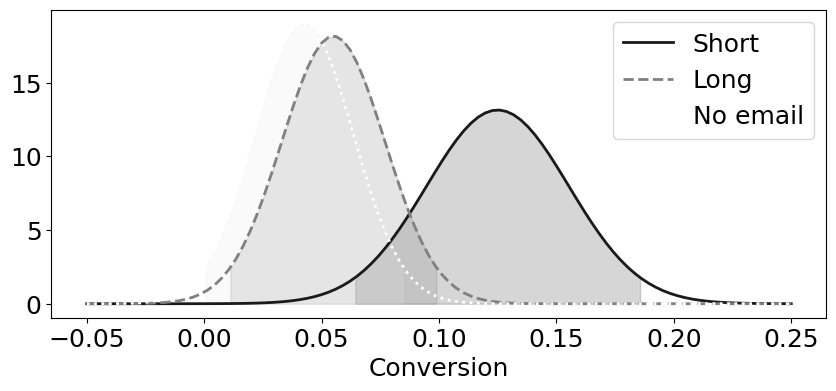

In [24]:
plt.figure(figsize=(10,4))

x = np.linspace(-0.05, .25, 100)
short_dist = stats.norm.pdf(x, short_email.mean(), short_email.sem())
plt.plot(x, short_dist, lw=2, label="Short", linestyle=linestyle[0])
plt.fill_between(x.clip(ci(short_email)[0], ci(short_email)[1]), 0, short_dist, alpha=0.2, color="0.2")

long_dist = stats.norm.pdf(x, long_email.mean(), long_email.sem())
plt.plot(x, long_dist, lw=2, label="Long", linestyle=linestyle[1])
plt.fill_between(x.clip(ci(long_email)[0], ci(long_email)[1]), 0, long_dist, alpha=0.2, color="0.5")

no_email_dist = stats.norm.pdf(x, no_email.mean(), no_email.sem())
plt.plot(x, no_email_dist, lw=2, label="No email", linestyle=linestyle[2])
plt.fill_between(x.clip(ci(no_email)[0], ci(no_email)[1]), 0, no_email_dist, alpha=0.2, color="0.9")

plt.xlabel("Conversion")
plt.legend()

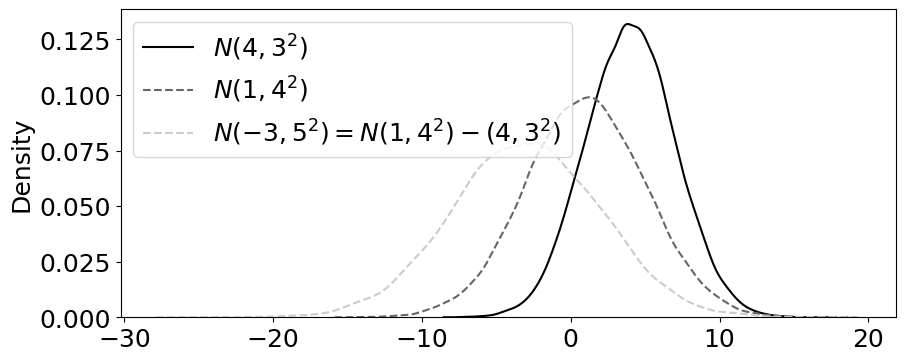

In [26]:
import seaborn as sns
from matplotlib import pyplot as plt

np.random.seed(123)

n1 = np.random.normal(4, 3, 30000)
n2 = np.random.normal(1, 4, 30000)
n_diff = n2 - n1

plt.figure(figsize=(10,4))
sns.distplot(n1, hist=False, label="$N(4,3^2)$", color="0.0", kde_kws={"linestyle":linestyle[0]})
sns.distplot(n2, hist=False, label="$N(1,4^2)$", color="0.4", kde_kws={"linestyle":linestyle[1]})
sns.distplot(n_diff, hist=False,
             label=f"$N(-3, 5^2) = N(1,4^2) - (4,3^2)$", color="0.8", kde_kws={"linestyle":linestyle[1]})
plt.legend();

In [27]:
diff_mu = short_email.mean() - no_email.mean()
diff_se = np.sqrt(no_email.sem()**2 + short_email.sem()**2)

ci = (diff_mu - 1.96*diff_se, diff_mu + 1.96*diff_se)
print(f'95% CI for the difference (short email - no email):\n{ci}')

95% CI for the difference (short email - no email):
(0.010239808474398426, 0.15465380854687816)


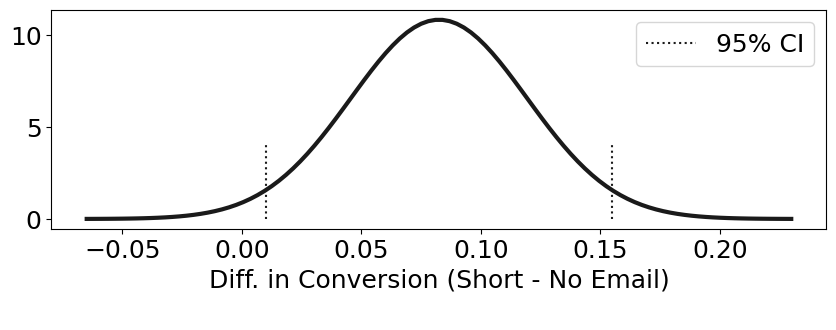

In [28]:
x = np.linspace(diff_mu - 4*diff_se, diff_mu + 4*diff_se, 100)
y = stats.norm.pdf(x, diff_mu, diff_se)

plt.figure(figsize=(10,3))
plt.plot(x, y, lw=3)
plt.vlines(ci[1], ymin=0, ymax=4, ls="dotted")
plt.vlines(ci[0], ymin=0, ymax=4, ls="dotted", label="95% CI")
plt.xlabel("Diff. in Conversion (Short - No Email)\n")
plt.legend()
plt.subplots_adjust(bottom=0.15)

2.7.1 귀무가설

In [29]:
#신뢰구간 이동
diff_mu_shifted = short_email.mean() - no_email.mean() - 0.01
diff_se = np.sqrt(no_email.sem()**2 + short_email.sem()**2)

ci = (diff_mu_shifted - 1.96*diff_se, diff_mu_shifted + 1.96*diff_se)
print(f'95% CI 1% difference between (short email - no email):\n{ci}')

95% CI 1% difference between (short email - no email):
(0.00023980847439843134, 0.14465380854687815)


2.7.2 검정통계량

In [30]:
t_stat = (diff_mu - 0) / diff_se
t_stat

2.237951231871536

2.8 P값

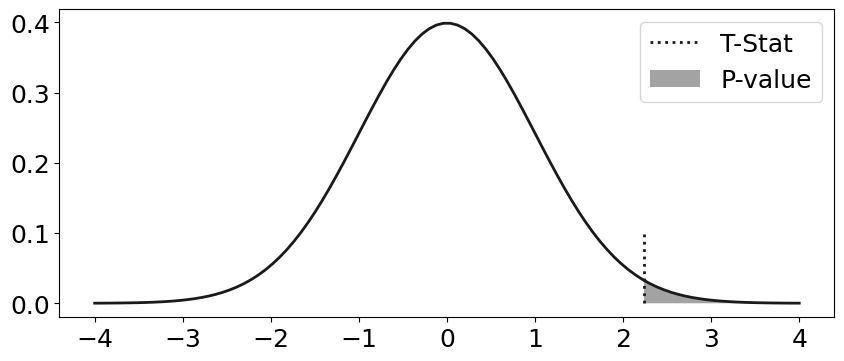

In [31]:
x = np.linspace(-4, 4, 100)
y = stats.norm.pdf(x, 0, 1)

plt.figure(figsize=(10,4))
plt.plot(x, y, lw=2)
plt.vlines(t_stat, ymin=0, ymax=0.1, ls="dotted", label="T-Stat", lw=2)
plt.fill_between(x.clip(t_stat), 0, y, alpha=0.4, label="P-value")
plt.legend()

In [32]:
print('p-value:', (1 - stats.norm.cdf(t_stat))*2)

p-value: 0.025224235562152142
